In [1]:
import os

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from utils import constants

# Extract Metadata from .mat Files

In [29]:
# Directory where the no bandpass signals are stored
data_dir = '/shared/rsaas/nschiou2/FOS/matfiles/voxel_space/pc0.1-12avg_rl_cropped/'

In [117]:
def read_voxel_data(data_dir, fname):
    pc00 = sio.loadmat(os.path.join(data_dir, fname))
    
    subject = fname[3:6]
    montage = fname.strip('.avm')[-2:]
    submontages = list(montage)
    boxy_hdr = {
        k: v for (k, v) in zip(
            list(pc00['boxy_hdr'].dtype.fields),
            [v[0][0] for v in pc00['boxy_hdr'][0][0]]
        )
    }
    fs = boxy_hdr['sample_rate']
    events = pd.DataFrame(pc00['trial_data'][0][0][0], columns=['event', 'trial_type'])
    data_type_dict = {
        ('voxel_avg', 0): 'dc_vox',
        ('voxel_avg', 1): 'ac_vox',
        ('voxel_avg', 2): 'ph_vox',
    }
    data_map = {
        (0, 0): 'L_values',
        (0, 1): 'L_count',
        (1, 0): 'R_values',
        (1, 1): 'R_count',
    }
    montage_map = {
        'ab': 'A',
        'cd': 'B',
        'ef': 'C',
        'gh': 'D',
    }
    
    result = pd.DataFrame(columns=['subject_id', 'montage'])
    meta_dict = {}
    meta_dict['subject_id'] = subject
    meta_dict['montage'] = montage_map[montage]
    submontage_meta_dict = {
        0: {},
        1: {},
    }
    # Iterate over DC/AC/Phase data
    for (k, i), v in data_type_dict.items():
        data = pc00[k][0][0][i]
        # Iterate over hempiswhere and values vs. counts combinations
        for (hemi, map_type), suffix in data_map.items():
            new_key = f'{v}_{suffix}'
            if map_type == 0:
                # Get metadata from paired sub-montage averages
                vmin_comb = np.nanmin(data[:, :, :, :, hemi])  # minimum value across timesteps and trials
                vmax_comb = np.nanmax(data[:, :, :, :, hemi])  # maximum value across timesteps and trials
                meta_dict[f'{new_key}_min'] = vmin_comb
                meta_dict[f'{new_key}_max'] = vmax_comb
            # Get metadata from individual sub-montages
            comb_chan_sum = 0
            for idx, sm in enumerate(submontages):
                submontage_meta_dict[idx]['subject_id'] = subject
                submontage_meta_dict[idx]['montage'] = sm
                submontage_fname = f'psc{subject}{sm}.avm'
                sub = sio.loadmat(os.path.join(data_dir, submontage_fname), appendmat=False)
                sub_data = sub[k[:-4]][0][0][i]
                if map_type == 0:
                    vmin = np.nanmin(sub_data[:, :, :, :, hemi, map_type])
                    vmax = np.nanmax(sub_data[:, :, :, :, hemi, map_type])
                    submontage_meta_dict[idx][f'{new_key}_min'] = vmin
                    submontage_meta_dict[idx][f'{new_key}_max'] = vmax
                elif map_type == 1:
                    vsum = np.median(
                        np.nansum(sub_data[:, :, :, :, hemi, map_type], axis=(0, 1)),
                        axis=(0, 1))
                    num_nonzero_vox = np.mean(
                        np.sum(sub_data[:, :, :, :, hemi, map_type] != 0, axis=(0, 1)),
                        axis=(0, 1))
                    # Keep track of number of channels per voxel for paired montage
                    if idx == 0:
                        comb_count = sub_data[:, :, :, :, hemi, map_type]
                    elif idx == 1:
                        comb_count += sub_data[:, :, :, :, hemi, map_type]
                    comb_chan_sum += vsum
                    submontage_meta_dict[idx][f'{new_key}_viable_chan'] = vsum
                    submontage_meta_dict[idx][f'{new_key}_nonzero_vox'] = num_nonzero_vox
            if map_type == 1:
                num_nonzero_vox = np.mean(
                    np.sum(comb_count != 0, axis=(0, 1)),
                    axis=(0, 1))
                meta_dict[f'{new_key}_viable_chan'] = comb_chan_sum
                meta_dict[f'{new_key}_nonzero_vox'] = num_nonzero_vox
    
    result = result.append(meta_dict, ignore_index=True)
    result = result.append(submontage_meta_dict[0], ignore_index=True)
    result = result.append(submontage_meta_dict[1], ignore_index=True)
    return result

In [ ]:
montages = ['ab', 'cd', 'ef', 'gh']

df = pd.DataFrame()
for subject in tqdm(constants.SUBJECT_IDS, leave=False):
    for montage in tqdm(montages, leave=False):
        fname = f'psc{subject}{montage}.avm'
        try:
            temp = read_voxel_data(data_dir, fname)
        except FileNotFoundError:
            continue
        df = df.append(temp, ignore_index=True)

df = df.assign(ac_vox_total_count_viable_chan=
               lambda x: x.ac_vox_L_count_viable_chan + x.ac_vox_R_count_viable_chan)
df = df.assign(dc_vox_total_count_viable_chan=
               lambda x: x.dc_vox_L_count_viable_chan + x.dc_vox_R_count_viable_chan)
df = df.assign(ph_vox_total_count_viable_chan=
               lambda x: x.ph_vox_L_count_viable_chan + x.ph_vox_R_count_viable_chan)
df = df.assign(ac_vox_total_count_nonzero_vox=
               lambda x: x.ac_vox_L_count_nonzero_vox + x.ac_vox_R_count_nonzero_vox)
df = df.assign(dc_vox_total_count_nonzero_vox=
               lambda x: x.dc_vox_L_count_nonzero_vox + x.dc_vox_R_count_nonzero_vox)
df = df.assign(ph_vox_total_count_nonzero_vox=
               lambda x: x.ph_vox_L_count_nonzero_vox + x.ph_vox_R_count_nonzero_vox)
df = df.assign(ac_vox_total_avg_chan_vox=
               lambda x: x.ac_vox_total_count_viable_chan / x.ac_vox_total_count_nonzero_vox)
df = df.assign(dc_vox_total_avg_chan_vox=
               lambda x: x.dc_vox_total_count_viable_chan / x.dc_vox_total_count_nonzero_vox)
df = df.assign(ph_vox_total_avg_chan_vox=
               lambda x: x.ph_vox_total_count_viable_chan / x.ph_vox_total_count_nonzero_vox)

In [140]:
df.columns

Index(['subject_id', 'montage', 'ac_vox_L_count_nonzero_vox',
       'ac_vox_L_count_viable_chan', 'ac_vox_L_values_max',
       'ac_vox_L_values_min', 'ac_vox_R_count_nonzero_vox',
       'ac_vox_R_count_viable_chan', 'ac_vox_R_values_max',
       'ac_vox_R_values_min', 'dc_vox_L_count_nonzero_vox',
       'dc_vox_L_count_viable_chan', 'dc_vox_L_values_max',
       'dc_vox_L_values_min', 'dc_vox_R_count_nonzero_vox',
       'dc_vox_R_count_viable_chan', 'dc_vox_R_values_max',
       'dc_vox_R_values_min', 'ph_vox_L_count_nonzero_vox',
       'ph_vox_L_count_viable_chan', 'ph_vox_L_values_max',
       'ph_vox_L_values_min', 'ph_vox_R_count_nonzero_vox',
       'ph_vox_R_count_viable_chan', 'ph_vox_R_values_max',
       'ph_vox_R_values_min', 'ac_vox_total_count_viable_chan',
       'dc_vox_total_count_viable_chan', 'ph_vox_total_count_viable_chan',
       'ac_vox_total_count_nonzero_vox', 'dc_vox_total_count_nonzero_vox',
       'ph_vox_total_count_nonzero_vox', 'ac_vox_total_avg_chan_

In [141]:
df

,subject_id,montage,ac_vox_L_count_nonzero_vox,ac_vox_L_count_viable_chan,ac_vox_L_values_max,ac_vox_L_values_min,ac_vox_R_count_nonzero_vox,ac_vox_R_count_viable_chan,ac_vox_R_values_max,ac_vox_R_values_min,...,ph_vox_R_values_min,ac_vox_total_count_viable_chan,dc_vox_total_count_viable_chan,ph_vox_total_count_viable_chan,ac_vox_total_count_nonzero_vox,dc_vox_total_count_nonzero_vox,ph_vox_total_count_nonzero_vox,ac_vox_total_avg_chan_vox,dc_vox_total_avg_chan_vox,ph_vox_total_avg_chan_vox
0,127,A,36.000000,138.0,0.410299,-0.252894,42.000000,164.0,0.658634,-0.629997,...,-0.625020,302.0,302.0,302.0,78.000000,78.000000,78.000000,3.871795,3.871795,3.871795
1,127,a,15.000000,42.0,0.270627,-0.252894,34.000000,99.0,0.658634,-0.629997,...,-0.625020,141.0,141.0,141.0,49.000000,49.000000,49.000000,2.877551,2.877551,2.877551
2,127,b,21.000000,96.0,0.410299,-0.243074,17.000000,65.0,0.532448,-0.499380,...,-0.271745,161.0,161.0,161.0,38.000000,38.000000,38.000000,4.236842,4.236842,4.236842
3,127,B,40.049528,233.0,0.647379,-0.625426,36.653302,111.0,0.832403,-0.503023,...,-0.395085,344.0,344.0,344.0,76.702830,76.702830,76.702830,4.484841,4.484841,4.484841
4,127,c,19.900943,89.0,0.226194,-0.260690,24.603774,66.0,0.301938,-0.356926,...,-0.287044,155.0,155.0,155.0,44.504717,44.504717,44.504717,3.482777,3.482777,3.482777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,516,e,38.000000,144.0,0.425317,-0.431325,38.000000,172.0,0.351270,-0.397581,...,-0.143507,316.0,316.0,316.0,76.000000,76.000000,76.000000,4.157895,4.157895,4.157895
131,516,f,0.000000,0.0,NaN,NaN,2.000000,2.0,0.391977,-0.308060,...,-0.086830,2.0,2.0,2.0,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
132,516,D,35.000000,135.0,0.245639,-0.223853,38.000000,165.0,0.253948,-0.240961,...,-0.180049,300.0,300.0,300.0,73.000000,73.000000,73.000000,4.109589,4.109589,4.109589
133,516,g,33.000000,133.0,0.245639,-0.223853,38.000000,164.0,0.253948,-0.240961,...,-0.180049,297.0,297.0,297.0,71.000000,71.000000,71.000000,4.183099,4.183099,4.183099


In [142]:
df.to_parquet('subject_voxel_space_metadata.parquet', index=False)

# Plot statistics

In [2]:
df = pd.read_parquet('subject_voxel_space_metadata.parquet')

## Viable channels

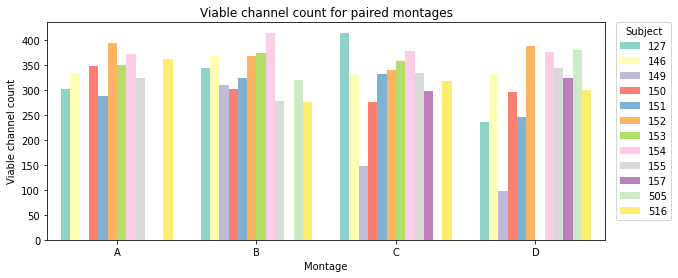

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.barplot(data=df[df['montage'].isin(['A', 'B', 'C', 'D'])],
            x='montage', y='ph_vox_total_count_viable_chan', hue='subject_id',
            palette='Set3', saturation=1.5, ax=ax)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Viable channel count for paired montages')
plt.xlabel('Montage')
plt.ylabel('Viable channel count');

In [6]:
temp = df[df['montage'].isin(['A', 'B', 'C', 'D'])]
temp = temp.replace(0, np.nan)
max_idx = temp[['subject_id', 'montage', 'ph_vox_total_count_viable_chan']].groupby('subject_id').idxmax()['ph_vox_total_count_viable_chan']
temp[['subject_id', 'montage', 'ph_vox_total_count_viable_chan']].loc[max_idx.values, :]

,subject_id,montage,ph_vox_total_count_viable_chan
6,127,C,415.0
15,146,B,369.0
24,149,B,311.0
33,150,A,348.0
51,151,C,333.0
57,152,A,394.0
72,153,B,374.0
84,154,B,414.0
102,155,D,344.0
114,157,D,324.0


In [146]:
temp[['subject_id', 'montage', 'ph_vox_total_count_viable_chan']]

,subject_id,montage,ph_vox_total_count_viable_chan
0,127,A,302.0
3,127,B,344.0
6,127,C,415.0
9,127,D,237.0
12,146,A,335.0
15,146,B,369.0
18,146,C,331.0
21,146,D,333.0
24,149,B,311.0
27,149,C,147.0


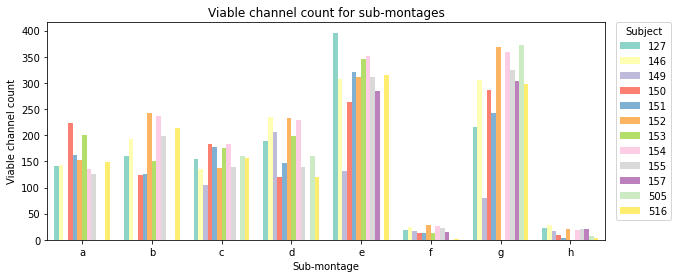

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.barplot(data=df[df['montage'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])],
            x='montage', y='ph_vox_total_count_viable_chan', hue='subject_id',
            palette='Set3', saturation=1.5, ax=ax)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Viable channel count for sub-montages')
plt.xlabel('Sub-montage')
plt.ylabel('Viable channel count');

## Viable voxels

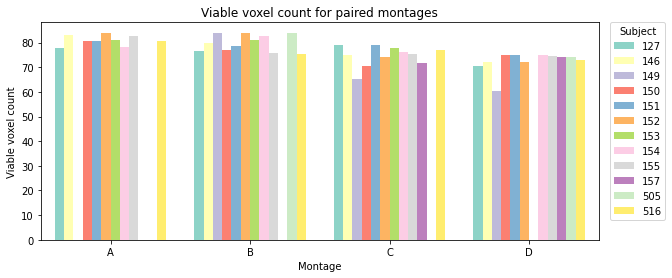

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.barplot(data=df[df['montage'].isin(['A', 'B', 'C', 'D'])],
            x='montage', y='ph_vox_total_count_nonzero_vox', hue='subject_id',
            palette='Set3', saturation=1.5, ax=ax)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Viable voxel count for paired montages')
plt.xlabel('Montage')
plt.ylabel('Viable voxel count');

In [9]:
temp = df[df['montage'].isin(['A', 'B', 'C', 'D'])]
max_idx = temp[['subject_id', 'montage', 'ph_vox_total_count_nonzero_vox']].groupby('subject_id').idxmax()['ph_vox_total_count_nonzero_vox']
temp[['subject_id', 'montage', 'ph_vox_total_count_nonzero_vox']].loc[max_idx.values, :]

,subject_id,montage,ph_vox_total_count_nonzero_vox
6,127,C,78.881690
12,146,A,82.949451
24,149,B,84.000000
33,150,A,80.471491
45,151,A,80.756892
57,152,A,84.000000
69,153,A,81.000000
84,154,B,82.596372
93,155,A,82.614085
114,157,D,74.000000


In [10]:
temp[['subject_id', 'montage', 'ph_vox_total_count_nonzero_vox']]

,subject_id,montage,ph_vox_total_count_nonzero_vox
0,127,A,78.000000
3,127,B,76.702830
6,127,C,78.881690
9,127,D,70.347087
12,146,A,82.949451
15,146,B,80.000000
18,146,C,75.000000
21,146,D,72.000000
24,149,B,84.000000
27,149,C,65.300439


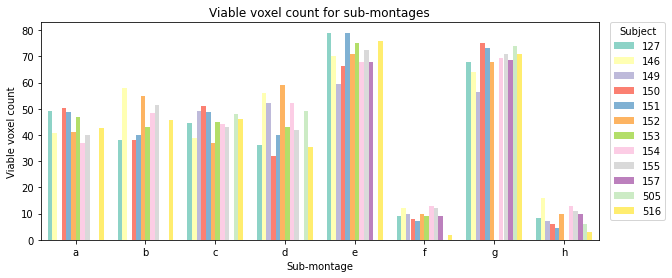

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.barplot(data=df[df['montage'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])],
            x='montage', y='ph_vox_total_count_nonzero_vox', hue='subject_id',
            palette='Set3', saturation=1.5, ax=ax)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Viable voxel count for sub-montages')
plt.xlabel('Sub-montage')
plt.ylabel('Viable voxel count');

## Viable channels / voxel

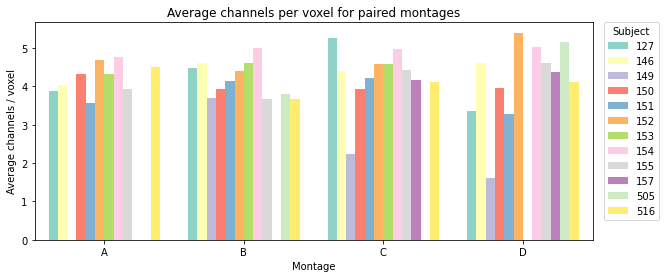

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.barplot(data=df[df['montage'].isin(['A', 'B', 'C', 'D'])],
            x='montage', y='ph_vox_total_avg_chan_vox', hue='subject_id',
            palette='Set3', saturation=1.5, ax=ax)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Average channels per voxel for paired montages')
plt.xlabel('Montage')
plt.ylabel('Average channels / voxel');

In [153]:
temp = df[df['montage'].isin(['A', 'B', 'C', 'D'])]
max_idx = temp[['subject_id', 'montage', 'ph_vox_total_avg_chan_vox', 'ph_vox_total_count_nonzero_vox']].groupby('subject_id').idxmax()['ph_vox_total_count_nonzero_vox']
temp[['subject_id', 'montage', 'ph_vox_total_avg_chan_vox']].loc[max_idx.values, :]

,subject_id,montage,ph_vox_total_avg_chan_vox
6,127,C,5.261043
12,146,A,4.038604
24,149,B,3.702381
33,150,A,4.324513
45,151,A,3.566259
57,152,A,4.690476
69,153,A,4.333333
84,154,B,5.012327
93,155,A,3.933954
114,157,D,4.378378


In [154]:
temp[['subject_id', 'montage', 'ph_vox_total_avg_chan_vox']]

,subject_id,montage,ph_vox_total_avg_chan_vox
0,127,A,3.871795
3,127,B,4.484841
6,127,C,5.261043
9,127,D,3.369009
12,146,A,4.038604
15,146,B,4.612500
18,146,C,4.413333
21,146,D,4.625000
24,149,B,3.702381
27,149,C,2.251133
